# Conflicts for land in Brazil - Data Analysis

#### Import modules

In [5]:
import pandas as pd
from IPython.display import clear_output as co
import seaborn as sns; sns.set()

#### Load TER CPT

In [8]:
cpt = pd.read_excel('Conflitos de Terra-CPT-2000-2011.xlsx', sheet_name=None)['Plan1']

cpt = cpt.iloc[:-1].fillna(0)
cpt['MUN'] = cpt['MUN'].apply(lambda value: value.strip() if value.startswith(' ') else value)

cpt.head(5)

,CUGN,CUGT,MUN,UF,FF,FFSITGEO,CONF2000,CONF2001,CONF2002,CONF2003,CONF2004,CONF2005,CONF2006,CONF2007,CONF2008,CONF2009,CONF2010,CONF2011
0,1100015.0,1100015.0,Alta Floresta D'Oeste,RO,1.0,2.0,1,0,0,1,0,2,0,2,0.0,2.0,1.0,1.0
1,1100023.0,1100023.0,Ariquemes,RO,0.0,0.0,0,3,2,2,1,2,3,2,0.0,2.0,2.0,3.0
2,1100031.0,1100031.0,Cabixi,RO,1.0,2.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0
3,1100049.0,1100049.0,Cacoal,RO,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,2.0
4,1100056.0,1100056.0,Cerejeiras,RO,1.0,3.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0


#### Load BASE-LENTO dataset

In [7]:
dfs = pd.read_excel('BASELEMTO_2011-2021.xlsx', sheet_name=None)

#### Extract land conflicts dataset from BASE-LENTO

In [8]:
land = dfs['TER-2011-2021'].iloc[:, :34].copy()

land['Município'] = land['Município'].apply(lambda value: value.replace(' D&#39', ''))
datetime_str = land['Data'].apply(lambda value: type(value)==str)
land.loc[datetime_str, 'Data'] = pd.to_datetime(land['Data'][datetime_str], dayfirst=True, yearfirst=False)

land.head(1)

,FichaLemto,Ficha,UF,Região,Bioma (ZT),Município,Geocódigo,Local,Local Secundário,Data,...,Grilagem,Incêndios,Omissão/Conivência,Impedimento de acesso a áreas de uso coletivo,Violações nas condições de existência,Soma Violências,Categoria sofreu ação,Categoria causou ação,Tipo de Violência,Eixos de Violência
0,TER-2011-2021-00006,MA1301,AC,Norte,Amazonia,Acrelândia,1200013,Assent. Califórnia/Suzano Papel e Celulose,"Assent. Califórnia/Empresas CVRD, Ferro Gusa C...",2011-05-18 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,Assentado,Mineradora,Danos,Terra


#### Load list of Brazilian cities in frontiers

In [9]:
frontier_cities = pd.read_html('https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_fronteiri%C3%A7os_do_Brasil')

city_value_map = lambda value: value.split(' – ' if ' – ' in value else ' - ')[1]

frontier_cities = frontier_cities[2]
frontier_cities['Município'] = frontier_cities['Município'].apply(city_value_map)

frontier_cities.head()

,Município,Estado,Área territorial,População (IBGE/2007),Densidade demográfica (hab/km2),PIB (IBGE/2005,PIB per capita (R$),IDH/2000
0,Aceguá,Rio Grande do Sul,1550.0,4138.0,266,71.638.000,17.266,ni
1,Acrelândia,Acre,1575.0,11520.0,731,114.350.000,9.986,0680
2,Alecrim,Rio Grande do Sul,315.0,7357.0,2335,44.373.000,5.944,0743
3,Almeirim,Pará,72960.0,30903.0,42,462.258.000,13.485,0745
4,Alta Floresta d'Oeste,Rondônia,7067.0,23857.0,337,186.812.000,6.525,0715


---

# Build sorted pivot of the conflicts dataset

## Sort by city and year

In [10]:
from copy import deepcopy

def multiclass_column_pivot(df, key, sep=', '):
    multiclass_list = df[key].apply(lambda value: value.split(sep)).tolist()
    df = df.copy(); n_rows = len(df)
    index = df.index.tolist()
    dup_rows, new_rows = [], []
    for i, idx in enumerate(index):
        if i%20 == 0: co(True); print(f'rows spreaded: {i+1}/{n_rows}')
        values = multiclass_list[i]
        if len(values) > 1:
            dup_rows.append(idx)
        row = df.loc[idx].copy()
        for value in values:
            row[key] = value
            new_rows.append(row.copy())
    return pd.concat(new_rows, axis=1).T.reset_index(drop=True)

key = 'Município'
df = land

df_pivot = multiclass_column_pivot(df, key, sep=', ')
df_pivot['Ano'] = pd.DatetimeIndex(df_pivot['Data']).year

sort_cols = ['Município', 'Ano', 'Data']
df_sort = pd.concat([df_pivot[sort_cols], df_pivot.drop(sort_cols, axis=1)], axis=1).sort_values(sort_cols)

rows spreaded: 2641/2648


## Data cleaning: Land dataset pivot 2011-2021

In [11]:
# missing = list(set(cpt['MUN'].tolist()).difference(count.index.tolist()))
# print('Cities missing in primary dataset:\n\n', missing); print('\n')

missing = list(set(df_sort['Município'].tolist()).difference(cpt['MUN'].tolist()))
print('Cities missing in secondary dataset:\n\n', missing); print('\n')

# City renaming map
city_name_map = {
    'Diamante;Oeste': "Diamante D'Oeste",
    'Glória;Oeste': "Glória D'Oeste",
    'Pimenteiras': "Pimenteiras do Oeste",
    'Alta Floresta;Oeste': "Alta Floresta D'Oeste",
    'Alvorada;Oeste': "Alvorada D'Oeste",
    'Conquista;Oeste': "Conquista D'Oeste",
    'Nova Brasilândia;Oeste': "Nova Brasilândia D'Oeste",
    'Sant&#39;Ana do Livramento': "Sant'Ana do Livramento",    
}

# RENAME CITIES TO MATCH PREVIOUS STANDARD. 
df_sort['Município'] = df_sort['Município'].apply(lambda value: value if value not in city_name_map else city_name_map[value])

# Show that there are no cities missing in secondary dataset anymore.
missing = list(set(df_sort['Município'].tolist()).difference(cpt['MUN'].tolist()))
print('Cities missing after city name formatting:\n\n', missing)

Cities missing in secondary dataset:

 ['Nova Brasilândia;Oeste', 'Diamante;Oeste', 'Conquista;Oeste', 'Alta Floresta;Oeste', 'Glória;Oeste', 'Sant&#39;Ana do Livramento', 'Pimenteiras', 'Alvorada;Oeste']


Cities missing after city name formatting:

 []


## Save sorted pivot dataset

In [126]:
df_sort.to_excel('Dados/ter-ordenado.xlsx', index=False)

df_sort.head()

<ipython-input-126-8cdda2da2a8e>:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.2.9' currently installed).
  df_sort.to_excel('Dados/ter-ordenado.xlsx', index=False)


,Município,Ano,Data,FichaLemto,Ficha,UF,Região,Bioma (ZT),Geocódigo,Local,...,Grilagem,Incêndios,Omissão/Conivência,Impedimento de acesso a áreas de uso coletivo,Violações nas condições de existência,Soma Violências,Categoria sofreu ação,Categoria causou ação,Tipo de Violência,Eixos de Violência
3553,Abelardo Luz,2011,2011-06-06,TER-2011-2021-00001,MT310,SC,Sul,Mata Atlantica,4200101,Assentamento Santa Rosa I e II,...,NaN,NaN,NaN,NaN,NaN,NaN,Assentado,Fazendeiro,Ameaça de Morte,Terra
3562,Abelardo Luz,2012,2012-02-28,TER-2011-2021-01643,AP143,SC,Sul,Mata Atlantica,4219507,Fazenda Santa Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,Posseiro,Empresário Internacional,Intimidação,Terra
3554,Abelardo Luz,2012,2012-06-21,TER-2011-2021-00821,MT310,SC,Sul,Mata Atlantica,4200101,Assentamento Santa Rosa I e II,...,NaN,NaN,NaN,NaN,NaN,NaN,Assentado,Fazendeiro,NaN,Terra
3558,Abelardo Luz,2012,2012-06-30,TER-2011-2021-01642,AP144,SC,Sul,Mata Atlantica,4219507,Ponta do Socorro e Vareiro,...,NaN,NaN,NaN,NaN,NaN,NaN,Posseiro,Empresário,Intimidação,Terra
3555,Abelardo Luz,2012,2012-07-17,TER-2011-2021-00822,MT310,SC,Sul,Mata Atlantica,4200101,Assentamento Santa Rosa I e II,...,NaN,NaN,NaN,NaN,NaN,NaN,Assentado,Fazendeiro,NaN,Terra


---
## Count conflicts by city and year

#### Reload sorted pivot dataset (city conflicts yearly time series)

In [3]:
import pandas as pd

df_sort = pd.read_excel('Dados/ter-ordenado.xlsx', index_col=None)

#### Count conflicts

In [130]:
col_count = 'Conflitos - TER'
count = df_sort.groupby(['Município', 'Ano']).apply(len).unstack().fillna(0)

display(count.head())
print('Cities in multivariate time series:', len(count))

<ipython-input-130-d76d9cb74c87>:4: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.2.9' currently installed).
  count.to_excel('Dados/ter-serie.xlsx', index=True)


Ano,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Município,,,,,,,,,,,
Abelardo Luz,1.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,5.0,0.0
Acrelândia,8.0,11.0,5.0,4.0,3.0,11.0,6.0,5.0,3.0,15.0,15.0
Alenquer,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,1.0,2.0,1.0
Almeirim,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
Alpestre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


Cities in multivariate time series: 237


#### Save city conflicts yearly time series

In [ ]:
count.to_excel('Dados/ter-serie.xlsx', index=True)

#### Reload city conflicts yearly time series

In [4]:
import pandas as pd

count = pd.read_excel('Dados/ter-serie.xlsx', index_col=0)

### Yearly time series by city

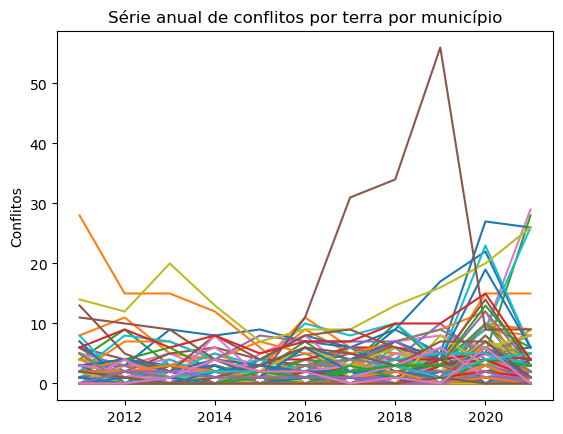

In [5]:
ax = count.T.plot(legend=[], title='Série anual de conflitos por terra por município', ylabel='Conflitos')

---
## Update conflicts by city yearly time series

#### Data formatting to match previous standard

In [6]:
# City column name
count.index.rename('MUN', inplace=True)

#  Year columns names
count.columns = 'CONF' + count.columns.astype(str)

# Drop columns name
# count.columns.rename(None, inplace=True)

#### Join datasets

In [11]:
cpt_up = cpt.join(count.drop('CONF2011', axis=1).astype(int), how='outer', on='MUN')
cpt_up_inner = cpt.join(count.drop('CONF2011', axis=1).astype(int), how='inner', on='MUN')

#### Save updated time series dataset

In [12]:
cpt_up.to_excel('Dados/ter-city-2000-2021.xlsx', index=False)
cpt_up_inner.to_excel('Dados/ter-city-frontier-2000-2021.xlsx', index=False)

cpt_up.head(5)

,CUGN,CUGT,MUN,UF,FF,FFSITGEO,CONF2000,CONF2001,CONF2002,CONF2003,...,CONF2012,CONF2013,CONF2014,CONF2015,CONF2016,CONF2017,CONF2018,CONF2019,CONF2020,CONF2021
0,1100015.0,1100015.0,Alta Floresta D'Oeste,RO,1.0,2.0,1,0,0,1,...,4.0,0.0,1.0,2.0,4.0,3.0,1.0,1.0,8.0,1.0
1,1100023.0,1100023.0,Ariquemes,RO,0.0,0.0,0,3,2,2,...,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1100031.0,1100031.0,Cabixi,RO,1.0,2.0,0,0,0,0,...,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
3,1100049.0,1100049.0,Cacoal,RO,0.0,0.0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1100056.0,1100056.0,Cerejeiras,RO,1.0,3.0,0,0,0,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#### Extra: Convert to geojson

In [4]:
cpt_up.head(5)

,CUGN,CUGT,MUN,UF,FF,FFSITGEO,CONF2000,CONF2001,CONF2002,CONF2003,...,CONF2012,CONF2013,CONF2014,CONF2015,CONF2016,CONF2017,CONF2018,CONF2019,CONF2020,CONF2021
0,1100015,1100015,Alta Floresta D'Oeste,RO,1,2,1,0,0,1,...,4.0,0.0,1.0,2.0,4.0,3.0,1.0,1.0,8.0,1.0
1,1100023,1100023,Ariquemes,RO,0,0,0,3,2,2,...,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1100031,1100031,Cabixi,RO,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
3,1100049,1100049,Cacoal,RO,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1100056,1100056,Cerejeiras,RO,1,3,0,0,0,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Exploratory data analysis

In [34]:
import matplotlib.pyplot as plt

#### Reload update time series

In [3]:
cpt_up = pd.read_excel('Dados/ter-city-2000-2021.xlsx')

# standard time serie format
ts = cpt_up.set_index('MUN').T.iloc[5:]; ts.index = list(map(lambda year: int(year[4:]), ts.index))

#### Filter cities in national frontier

In [78]:
in_frontier = frontier_cities['Município']

ts_frontier = ts.iloc[:, ts.columns.isin(in_frontier)]

#### Plot time serie comparison

- Cidades: 1717
- Cidades de Fronteira: 126 · 7.3%


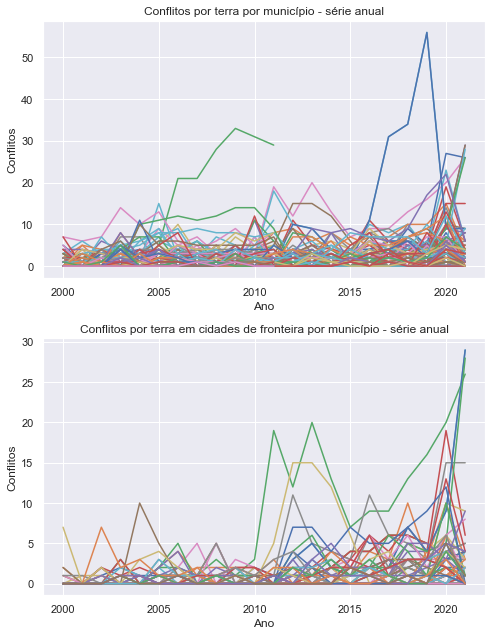

In [88]:
fig, axs = plt.subplots(2, 1, figsize=(7, 9), tight_layout=True)

ts.plot(
    legend=[],
    title='Conflitos por terra por município - série anual',
    xlabel='Ano', ylabel='Conflitos', ax=axs[0]
)
ts_frontier.plot(
    legend=[],
    title='Conflitos por terra em cidades de fronteira por município - série anual',
    xlabel='Ano', ylabel='Conflitos', ax=axs[1]
)

print(f'- Cidades: {ts.shape[1]}')
print(f'- Cidades de Fronteira: {ts_frontier.shape[1]} · {round(ts_frontier.shape[1] / ts.shape[1] * 100, 1)}%')

plt.show()

### States

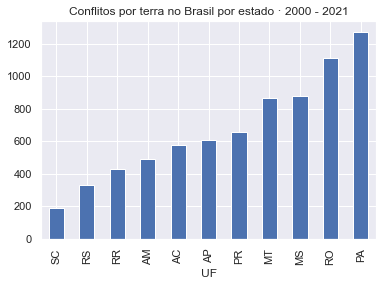

In [163]:
states = cpt_up['UF'].map(str.strip)
ax = pd.Series(cpt_up.iloc[:, 6:].sum(1).values, index=states).groupby('UF').sum().sort_values().plot.bar(
    title='Conflitos por terra no Brasil por estado · 2000 - 2021'
)

### Region

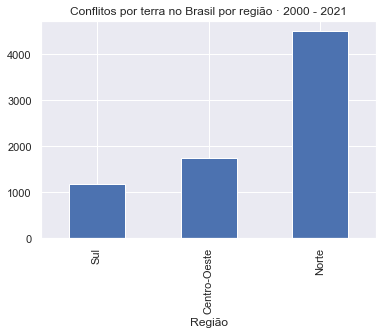

In [162]:
states_df = pd.read_html('https://www.estadosecapitaisdobrasil.com/')[0]
state_region_map = states_df.set_index('Sigla')['Região'].to_dict()

regions = cpt_up['UF'].map(str.strip).map(lambda item: state_region_map[item]).rename('Região')
ax = pd.Series(cpt_up.iloc[:, 6:].sum(1).values, index=regions).groupby('Região').sum().sort_values().plot.bar(
    title='Conflitos por terra no Brasil por região · 2000 - 2021'
)